In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Toyota.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_Auris,Seri_Avensis,Seri_Camry,...,Model_2.0 Sol Extra,Model_2.0 XL,Model_2.2 GL,Model_3.0 GX,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,575000,0.545455,-0.083333,-1.110577,-0.689139,NaN,NaN,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,195000,-0.272727,-0.333333,-0.942308,0.675266,0.0,0.0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,764900,0.363636,0.833333,0.182692,-0.726592,0.0,1.0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
3,904000,0.818182,0.833333,0.182692,-1.176554,0.0,0.0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,585000,0.363636,-0.083333,-1.110577,0.374532,4.0,0.0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_15968\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,45303.545957,2.529936e+09,50298.471964,33076.062306


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-05-23 21:36:27,243] A new study created in memory with name: no-name-807dfea0-a1d6-4b3e-8f85-883763907b8a
[I 2023-05-23 21:36:27,469] Trial 3 finished with value: 361086.768528766 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.03857502117410178, 'max_depth': 9, 'min_child_weight': 160}. Best is trial 3 with value: 361086.768528766.
[I 2023-05-23 21:36:27,472] Trial 4 finished with value: 496476.70750536455 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.004654797313845596, 'max_depth': 14, 'min_child_weight': 292}. Best is trial 3 with value: 361086.768528766.
[I 2023-05-23 21:36:27,507] Trial 0 finished with value: 465602.98210980796 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.01182098600909798, 'max_depth': 8, 'min_child_weight': 87}. Best is trial 3 with value: 361086.768528766.
[I 2023-05-23 21:36:27,514] Trial 1 finished with value: 62734.85318356253 and parameters: {'colsampl

[I 2023-05-23 21:36:28,872] Trial 30 finished with value: 144281.87478378782 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.13583242598384213, 'max_depth': 5, 'min_child_weight': 54}. Best is trial 25 with value: 55090.60795768588.
[I 2023-05-23 21:36:28,877] Trial 31 finished with value: 174662.1105356628 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.11419128842487547, 'max_depth': 5, 'min_child_weight': 52}. Best is trial 25 with value: 55090.60795768588.
[I 2023-05-23 21:36:29,018] Trial 32 finished with value: 154163.7840235227 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.1281037114791791, 'max_depth': 5, 'min_child_weight': 52}. Best is trial 25 with value: 55090.60795768588.
[I 2023-05-23 21:36:29,047] Trial 33 finished with value: 135121.24014919516 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.14313298190088602, 'max_depth': 5, 'min_child_weight': 

[I 2023-05-23 21:36:30,784] Trial 56 finished with value: 52353.85376797766 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.349265311442023, 'max_depth': 8, 'min_child_weight': 31}. Best is trial 56 with value: 52353.85376797766.
[I 2023-05-23 21:36:30,968] Trial 61 finished with value: 51204.12186151052 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.46849895329304986, 'max_depth': 8, 'min_child_weight': 36}. Best is trial 61 with value: 51204.12186151052.
[I 2023-05-23 21:36:31,102] Trial 62 finished with value: 55179.45957783502 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.3409002330839872, 'max_depth': 8, 'min_child_weight': 35}. Best is trial 61 with value: 51204.12186151052.
[I 2023-05-23 21:36:31,294] Trial 63 finished with value: 54191.32749945286 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.34611495800731623, 'max_depth': 8, 'min_child_weight': 40}.

[I 2023-05-23 21:36:32,869] Trial 90 finished with value: 60363.950269446614 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.25280553705362413, 'max_depth': 7, 'min_child_weight': 8}. Best is trial 86 with value: 50299.4200920412.
[I 2023-05-23 21:36:33,033] Trial 91 finished with value: 60789.95992146113 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.2471302378717203, 'max_depth': 7, 'min_child_weight': 1}. Best is trial 86 with value: 50299.4200920412.
[I 2023-05-23 21:36:33,106] Trial 92 finished with value: 63559.49859363059 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.24058112769475196, 'max_depth': 7, 'min_child_weight': 13}. Best is trial 86 with value: 50299.4200920412.
[I 2023-05-23 21:36:33,129] Trial 93 finished with value: 58543.65519859209 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.26317053234400883, 'max_depth': 7, 'min_child_weight': 14}. B

[I 2023-05-23 21:36:35,112] Trial 121 finished with value: 56384.44425662783 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.2908160874227444, 'max_depth': 8, 'min_child_weight': 48}. Best is trial 86 with value: 50299.4200920412.
[I 2023-05-23 21:36:35,137] Trial 124 finished with value: 64538.351981857275 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.31066579940898437, 'max_depth': 8, 'min_child_weight': 242}. Best is trial 86 with value: 50299.4200920412.
[I 2023-05-23 21:36:35,179] Trial 119 finished with value: 52907.41769392391 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.299302714883948, 'max_depth': 8, 'min_child_weight': 18}. Best is trial 86 with value: 50299.4200920412.
[I 2023-05-23 21:36:35,181] Trial 120 finished with value: 55301.05501931271 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.29032716637040873, 'max_depth': 8, 'min_child_weight': 3

[I 2023-05-23 21:36:37,225] Trial 148 finished with value: 50866.38544130705 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.47043752633302877, 'max_depth': 11, 'min_child_weight': 28}. Best is trial 128 with value: 49856.01580121905.
[I 2023-05-23 21:36:37,279] Trial 151 finished with value: 51534.067612316416 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.4805678375810354, 'max_depth': 11, 'min_child_weight': 30}. Best is trial 128 with value: 49856.01580121905.
[I 2023-05-23 21:36:37,307] Trial 152 finished with value: 53268.33930065814 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.35815494386092434, 'max_depth': 11, 'min_child_weight': 31}. Best is trial 128 with value: 49856.01580121905.
[I 2023-05-23 21:36:37,379] Trial 153 finished with value: 50188.70801858661 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.49596319452896187, 'max_depth': 11, 'min_child

[I 2023-05-23 21:36:39,406] Trial 180 finished with value: 56460.94937666744 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.2733560697389698, 'max_depth': 11, 'min_child_weight': 15}. Best is trial 128 with value: 49856.01580121905.
[I 2023-05-23 21:36:39,589] Trial 181 finished with value: 56030.27680144258 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.2756425987542426, 'max_depth': 11, 'min_child_weight': 16}. Best is trial 128 with value: 49856.01580121905.
[I 2023-05-23 21:36:39,650] Trial 182 finished with value: 53053.10431867791 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.3062954495111868, 'max_depth': 11, 'min_child_weight': 14}. Best is trial 128 with value: 49856.01580121905.
[I 2023-05-23 21:36:39,765] Trial 183 finished with value: 52669.99303128262 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.3071209156639248, 'max_depth': 12, 'min_child_wei

[I 2023-05-23 21:36:41,829] Trial 210 finished with value: 363628.5268284558 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.03648812318406998, 'max_depth': 11, 'min_child_weight': 9}. Best is trial 128 with value: 49856.01580121905.
[I 2023-05-23 21:36:41,956] Trial 212 finished with value: 513027.91800888383 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.0012457008388675082, 'max_depth': 11, 'min_child_weight': 1}. Best is trial 128 with value: 49856.01580121905.
[I 2023-05-23 21:36:41,988] Trial 211 finished with value: 50343.97697113951 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.3390094585612038, 'max_depth': 11, 'min_child_weight': 16}. Best is trial 128 with value: 49856.01580121905.
[I 2023-05-23 21:36:42,068] Trial 215 finished with value: 50165.55519544195 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.3533326300569732, 'max_depth': 11, 'min_child_

[I 2023-05-23 21:36:44,313] Trial 241 finished with value: 51012.89070652675 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.36894225649882056, 'max_depth': 14, 'min_child_weight': 28}. Best is trial 128 with value: 49856.01580121905.
[I 2023-05-23 21:36:44,368] Trial 242 finished with value: 50589.998245465154 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.3732922834801143, 'max_depth': 10, 'min_child_weight': 27}. Best is trial 128 with value: 49856.01580121905.
[I 2023-05-23 21:36:44,435] Trial 240 finished with value: 51053.95026274111 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.3644728772488353, 'max_depth': 10, 'min_child_weight': 27}. Best is trial 128 with value: 49856.01580121905.
[I 2023-05-23 21:36:44,727] Trial 244 finished with value: 145331.35235526922 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.12884431465152896, 'max_depth': 11, 'min_child

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 49856.0158
Best params:
	colsample_bytree: 0.9
	subsample: 1.0
	learning_rate: 0.35477418352952644
	max_depth: 9
	min_child_weight: 17


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)
grid_params = {"learning_rate": [0.1, 0.3],
                  "max_depth": [5,9],
                  "n_estimators": [500,750,1000],
               'colsample_bytree': [0.9],
               'subsample': [1],
               'min_child_weight': [17]
              }

grid_model = GridSearchCV(estimator=model,
                                  param_grid=grid_params,
                                  cv=3,
                                  verbose=True,
                                  n_jobs=1).fit(X_train,y_train)


grid_final_model = model.set_params(**grid_model.best_params_).fit(X_train,y_train)
    
cv_results = cross_validate(grid_final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
print("BEST PARAMS: ", grid_model.best_params_)
    
y_pred = grid_final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
BEST PARAMS:  {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 17, 'n_estimators': 500, 'subsample': 1}
{'TestDeger': 44681.36342056647, 'MSE': 2351657662.2893624, 'RMSE': 48493.89304117955, 'MAE': 32657.20267955044}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.9423933126707175

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.9359165831595342

In [17]:
marka_model = joblib.dump(grid_final_model, "Toyota.pkl")

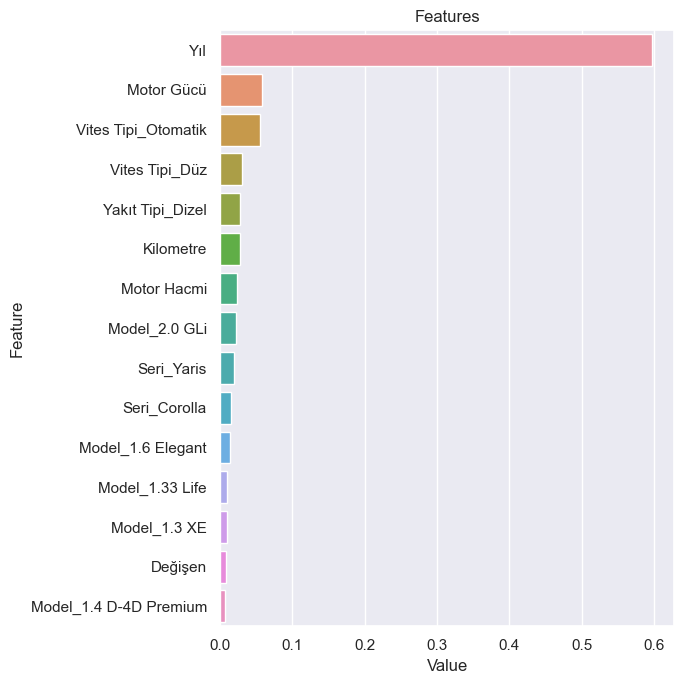

In [16]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(grid_final_model,X)